<a href="https://colab.research.google.com/github/zaryab-ali/genre-detection/blob/main/genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
#import tensorflow.keras as keras
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import os
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/grive')

Mounted at /content/grive


In [ ]:
DATA_PATH = "/content/grive/MyDrive/librosa folder/data_10.json"

In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return  X, y


if __name__ == "__main__":

    # load data
    X, y = load_data(DATA_PATH)

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    # build network topology
    model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

        # 1st dense layer
        keras.layers.Dense(512, activation='relu'),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu'),

        # 3rd dense layer
        keras.layers.Dense(64, activation='relu'),

        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=2)



In [ ]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))
    return predicted_index


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=10)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    pred = predict(model, X_to_predict, y_to_predict)

In [ ]:
def feature_extraction(file_path):
  x,sample_rate = librosa.load(file_path, res_type="kaiser_fast")
  mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=50).T, axis=0)

  return mfcc

In [ ]:
from google.colab import files
files.upload()

In [ ]:
features = {}
features["country_sample.mp3"]=feature_extraction("country_sample.mp3")

In [ ]:
features["country_sample.mp3"]

In [ ]:
predict(model, features["country_sample.mp3"],"country")

In [ ]:
print(X_to_predict)
print(y_to_predict)

[[[ 22.45935249]
  [ 68.42714691]
  [ -4.31240463]
  ...
  [ -0.92262417]
  [ -3.11159301]
  [ -4.2842989 ]]

 [[ 32.18489075]
  [ 67.76899719]
  [ -4.25516176]
  ...
  [  7.96655083]
  [  4.57237816]
  [  2.48261356]]

 [[  8.45665932]
  [ 74.61837769]
  [ -4.13142061]
  ...
  [  8.19894791]
  [  4.94136429]
  [ 10.4140234 ]]

 ...

 [[-24.72808647]
  [ 44.78092194]
  [  6.37504005]
  ...
  [ -0.87491369]
  [ -1.23188412]
  [  4.84141445]]

 [[-56.1646347 ]
  [ 46.20347595]
  [  1.75226212]
  ...
  [  0.38537371]
  [ -0.21025574]
  [  3.39758301]]

 [[-92.10816956]
  [ 52.22493744]
  [ -1.15574646]
  ...
  [  5.41520405]
  [ -0.45875514]
  [ -0.53940082]]]
7


In [ ]:
testing_path = "/content/grive/MyDrive/testing_folder/testing.json"

In [ ]:
X, y = load_data(testing_path)
X_train = X[..., np.newaxis]
x_to =X_train[0]
y_to = y[0]



print(x_to)
print(y_to)

predict(model,x_to,y_to)

[[[-855.63171387]
  [   0.        ]
  [   0.        ]
  ...
  [   0.        ]
  [   0.        ]
  [   0.        ]]

 [[-855.63171387]
  [   0.        ]
  [   0.        ]
  ...
  [   0.        ]
  [   0.        ]
  [   0.        ]]

 [[-855.63171387]
  [   0.        ]
  [   0.        ]
  ...
  [   0.        ]
  [   0.        ]
  [   0.        ]]

 ...

 [[-577.65686035]
  [ 165.37060547]
  [  20.58172989]
  ...
  [  -9.31544495]
  [ -13.91688251]
  [ -12.48733902]]

 [[-553.36700439]
  [ 155.1477356 ]
  [  23.60797501]
  ...
  [ -11.00204849]
  [ -11.10712147]
  [ -11.48139095]]

 [[-552.40100098]
  [ 165.26397705]
  [  22.98423004]
  ...
  [  -9.33197784]
  [  -5.06626225]
  [  -6.27314425]]]
0
1/1 [==============================] - 0s 37ms/step
Target: 0, Predicted label: [1]


In [ ]:
import os
os.mkdir("/content/ttt")
os.mkdir("/content/ttt/eee")

In [ ]:
!pip install Path
!pip install requests
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json
import os
import math
import librosa
from pathlib import Path
import requests

# os.mkdir("/content/ttt")
# os.mkdir("/content/ttt/eee")
DATASET_PATH = "/content/ttt"
JSON_PATH = "/content/testing.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5,out_file="audio.mp3"):


    # dictionary to store mapping, labels, and MFCCs
    url = "https://firebasestorage.googleapis.com/v0/b/products-c26e6.appspot.com/o/WhatsApp%20Audio%202023-03-13%20at%204.50.07%20PM.mp3?alt=media&token=b4be8a7d-2995-4ca7-b94e-c33767c4a82a"
    out_file = Path(f"/content/ttt/eee/{out_file}").expanduser()
    resp = requests.get(url)
    resp.raise_for_status()
    with open(out_file, "wb") as fout:
        fout.write(resp.content)


    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
                        print("{}, segment:{}".format(file_path, d + 1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

    testing_path="/content/testing.json"
    X, y = load_data(testing_path)
    X_train = X[..., np.newaxis]
    x_to =X_train[0]
    y_to = y[0]



    print(x_to)
    print(y_to)

    pred = predict(model,x_to,y_to)
    print(pred)

In [ ]:
!pip install pyngrok


In [ ]:
from flask import Flask
from pyngrok import ngrok
from urllib.parse import unquote
import json
import os
import math
import librosa
from pathlib import Path
import requests

# os.mkdir("/content/ttt")
# os.mkdir("/content/ttt/eee")
DATASET_PATH = "/content/ttt"
JSON_PATH = "/content/testing.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30  # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


port_no = 5000

app = Flask(__name__)
ngrok.set_auth_token("2IXKwQkflx7vu7q0FwBA7Uaj2yV_62xnbYLu3euksYJiUmLaT")
public_url = ngrok.connect(port_no).public_url


def save_mfcc(url, dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5,out_file="audio.mp3"):


    # dictionary to store mapping, labels, and MFCCs
    #url = "https://firebasestorage.googleapis.com/v0/b/products-c26e6.appspot.com/o/WhatsApp%20Audio%202023-03-13%20at%204.50.07%20PM.mp3?alt=media&token=b4be8a7d-2995-4ca7-b94e-c33767c4a82a"
    out_file = Path(f"/content/ttt/eee/{out_file}").expanduser()
    resp = requests.get(url)
    resp.raise_for_status()
    with open(out_file, "wb") as fout:
        fout.write(resp.content)


    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
                        print("{}, segment:{}".format(file_path, d + 1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


@app.route("/")
def shit():
  return f"hello"

@app.route("/final/<path:url>")
def download(url):
  temp = url
  save_mfcc(url,DATASET_PATH, JSON_PATH, num_segments=10)

  testing_path="/content/testing.json"
  X, y = load_data(testing_path)
  X_train = X[..., np.newaxis]
  x_to =X_train[0]
  y_to = y[0]

  print(x_to)
  print(y_to)
  print("so it works till here")

  pred = predict(model,x_to,y_to)
  print("this value isv  " + pred)
  return pred[0]


print(public_url)
app.run(port=port_no)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 130, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
179/179 [==============================] -

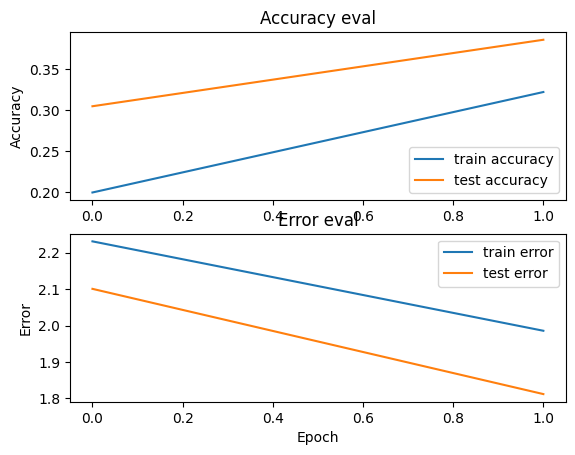

75/75 - 3s - loss: 1.8278 - accuracy: 0.3657 - 3s/epoch - 39ms/step

Test accuracy: 0.36565911769866943


In [ ]:

def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates RNN-LSTM model

    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=2)
    #model.save("/content/grive/MyDrive/trained_model/song_prediction.hdf5")
    with open("/content/song_prediction","wb") as filet:
      pickle.dump(model,filet)
    with open("/content/song_prediction_history","wb") as filet:
      pickle.dump(history,filet)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

In [ ]:
loaded_mod = pickle.load(open('/content/song_prediction','rb'))
with open('/content/grive/MyDrive/testing_folder/testing.json', "r") as fp:
    data = json.load(fp)

X = np.array(data["mfcc"])

prediction = loaded_mod.predict(X)

print(prediction)

predicted_index = np.argmax(prediction, axis=1)

print("******************************************************************")
print(predicted_index[0])




1/1 [==============================] - 1s 930ms/step
[[0.03956079 0.65620464 0.03004892 0.0215861  0.04321732 0.04903583
  0.04674875 0.04909974 0.05215708 0.0123408 ]
 [0.03717436 0.65770453 0.02866039 0.02431444 0.04555083 0.04860601
  0.04660218 0.04671148 0.05254648 0.01212924]
 [0.04887209 0.6333508  0.03594398 0.02133123 0.04561821 0.06206508
  0.0370436  0.04296953 0.05869785 0.01410756]
 [0.06332762 0.5697641  0.04855404 0.02197623 0.05305183 0.09166225
  0.04274026 0.02720362 0.06314369 0.01857645]
 [0.04623322 0.6233612  0.03682171 0.02254622 0.04610219 0.06088287
  0.04867127 0.04826194 0.05218433 0.01493509]
 [0.04647473 0.6265619  0.03516282 0.02174406 0.04626086 0.05826216
  0.04859164 0.05157553 0.05093119 0.01443517]
 [0.04340341 0.64094615 0.03395985 0.02233986 0.04521133 0.06067973
  0.04797872 0.04117195 0.05007085 0.01423821]
 [0.08992132 0.41922474 0.06636091 0.02319807 0.05655264 0.16161011
  0.04909548 0.02416208 0.07855087 0.0313237 ]
 [0.06125994 0.5836121  0.0

In [ ]:
model.save("bitch.h5")

In [ ]:
from tensorflow.keras.models import load_model
modd = load_model('bitch.h5')

with open('/content/grive/MyDrive/testing_folder/testing.json', "r") as fp:
    data = json.load(fp)

X = np.array(data["mfcc"])

prediction = modd.predict(X)

print(prediction)

predicted_index = np.argmax(prediction, axis=1)

print("******************************************************************")
print(predicted_index[0])

1/1 [==============================] - 1s 833ms/step
[[0.03956079 0.65620464 0.03004892 0.0215861  0.04321732 0.04903583
  0.04674875 0.04909974 0.05215708 0.0123408 ]
 [0.03717436 0.65770453 0.02866039 0.02431444 0.04555083 0.04860601
  0.04660218 0.04671148 0.05254648 0.01212924]
 [0.04887209 0.6333508  0.03594398 0.02133123 0.04561821 0.06206508
  0.0370436  0.04296953 0.05869785 0.01410756]
 [0.06332762 0.5697641  0.04855404 0.02197623 0.05305183 0.09166225
  0.04274026 0.02720362 0.06314369 0.01857645]
 [0.04623322 0.6233612  0.03682171 0.02254622 0.04610219 0.06088287
  0.04867127 0.04826194 0.05218433 0.01493509]
 [0.04647473 0.6265619  0.03516282 0.02174406 0.04626086 0.05826216
  0.04859164 0.05157553 0.05093119 0.01443517]
 [0.04340341 0.64094615 0.03395985 0.02233986 0.04521133 0.06067973
  0.04797872 0.04117195 0.05007085 0.01423821]
 [0.08992132 0.41922474 0.06636091 0.02319807 0.05655264 0.16161011
  0.04909548 0.02416208 0.07855087 0.0313237 ]
 [0.06125994 0.5836121  0.0